In [38]:
# 1. import module

import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from pycaret.regression import *

from sklearn.model_selection import train_test_split 
from sklearn import metrics
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import KFold

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_seq_items = None


from itertools import product
from py_module.load_data import load_data
from py_module.plot_data import plot_histogram
from py_module.regression import *
from py_module.pre_processing import *
from py_module.verify import *
from py_module.etc import *
from py_module.compare import *
import warnings, logging, sys
warnings.simplefilter(action='ignore', category=FutureWarning)     # pandas 등
logging.getLogger().handlers.clear()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

import logging, sys, warnings, pandas as pd

# ① logging 핸들러 리셋
logging.getLogger().handlers.clear()
logging.basicConfig(stream=sys.stdout, level=logging.INFO, force=True)

# ② pandas SettingWithCopyWarning 무시 (원인 해결 후에도 잔여 경고 차단용)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

import joblib


In [49]:
def get_outlier(df=None, column=None, weight=1.5):
    
    # column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    data = df[column]
    quantile_25 = np.percentile(data.values,10)  # 1/4 분위
    quantile_75 = np.percentile(data.values,90)  # 3/4 분위
    
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight  # 이상치 최소 기준
    highest_val = quantile_75 + iqr_weight # 이상치 최대 기준
    
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = data[(data < lowest_val) | (data > highest_val)].index
    
    return outlier_index

def outlier_remove(data) :
    col_input = list(data.columns)[:-2]
    col_input = list(data.columns)

    # outlier 탐색 및 제거
    outlier_index = {}
    for i, colName in enumerate(col_input):
        outlier_index[i] = get_outlier(df=data, column=f'{colName}', weight=1.5)
    outlier_index

    # 각각의 숫자들 리스트 안에 넣기
    outlier_list = []
    for i in range(len(outlier_index)):
        if list(outlier_index[i].values) == []:
            continue
        outlier_list.append(list(outlier_index[i].values))


    # 리스트 안의 리스트들을 하나로 합치기
    outlier_list = sum(outlier_list , [])
    print('개수:', len(outlier_list))

    # 중복 숫자 제거
    outlier_list = set(outlier_list)
    print('개수:', len(outlier_list))

    # 다시 리스트 타입으로 변환
    outlier_list = list(outlier_list)
    print(type(outlier_list))

    # 리스트 숫자 정렬
    outlier_list.sort()

    # outlier를 갖는 index에 해당하는 data drop
    for i in outlier_list:
        data.drop(i, axis=0, inplace=True)

    print(f'필터링 후 : {data.shape}')

    return data

def train_model(X,Y) :

    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state = 765)

    Z = pd.concat([X_train,Y_train],axis=1)
    param_grid = {
        "n_estimators": [1000, 5000, 10000, 20000],
        "learning_rate": [0.01, 0.05, 0.1, 0.15],
        "num_leaves": [3, 7, 11, 15],
    }

    best_model = None
    best_r2 = float("-inf")
    best_params = None

    for n_est, lr, n_leaf in product(
        param_grid["n_estimators"],
        param_grid["learning_rate"],
        param_grid["num_leaves"]
    ):
        model = LGBMRegressor(
            random_state=765,
            n_estimators=n_est,
            learning_rate=lr,
            num_leaves=n_leaf,
            max_depth=-1,
            objective="poisson",
            boosting_type="gbdt",
        )
        model.fit(X_train, Y_train)
        preds = model.predict(X_test)
        r2 = r2_score(Y_test, preds)

        if r2 > best_r2:
            best_r2 = r2
            best_model = model
            best_params = {
                "n_estimators": n_est,
                "learning_rate": lr,
                "num_leaves": n_leaf,
            }

    print(f"Best R2: {best_r2:.6f} with params: {best_params}")    
    

    return best_model, best_r2

def train_model_v2(X,Y) :

    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state = 765)

    Z = pd.concat([X_train,Y_train],axis=1)

    param_grid = {
        "n_estimators": [1000, 5000, 10000, 20000],
        "learning_rate": [0.01, 0.05, 0.1, 0.15],
        "num_leaves": [3, 7, 11, 15],
    }

    best_model = None
    best_r2 = float("-inf")
    best_params = None

    for n_est, lr, n_leaf in product(
        param_grid["n_estimators"],
        param_grid["learning_rate"],
        param_grid["num_leaves"]
    ):
        model = LGBMRegressor(
            random_state=765,
            n_estimators=n_est,
            learning_rate=lr,
            num_leaves=n_leaf,
            max_depth=-1,
            objective="poisson",
            boosting_type="gbdt",
        )
        model.fit(X_train, Y_train)
        preds = model.predict(X_test)
        r2 = r2_score(Y_test, preds)

        if r2 > best_r2:
            best_r2 = r2
            best_model = model
            best_params = {
                "n_estimators": n_est,
                "learning_rate": lr,
                "num_leaves": n_leaf,
            }

    print(f"Best R2: {best_r2:.6f} with params: {best_params}")    
    

    return best_model, X_train,X_test,Y_train,Y_test



In [51]:
column_names =  ["freq","input_voltage","w1","l1_leg","l1_top","l2","h1","l1_center",
                "Tx_turns","Tx_width","Tx_height","Tx_space_x","Tx_space_y","Tx_preg",
                "Rx_width","Rx_height","Rx_space_x","Rx_space_y","Rx_preg","g2",
                "Tx_layer_space_x","Tx_layer_space_y","Tx_current",
                "Ltx","Lrx1","Lrx2","M1","M2","k1","k2","Lmt","Lmr1","Lmr2",
                "Llt","Llr1","Llr2","Rtx","Rrx1","Rrx2",
                "Rx_current_optimetric","copperloss_Tx","copperloss_Rx1","copperloss_Rx2",
                "magnetizing_current_optimetric","coreloss","B_core","B_left","B_right","B_center","B_top_left","B_bottom_left","B_top_right","B_bottom_right",
                "magnetizing_copperloss_Tx","magnetizing_copperloss_Rx1","magnetizing_copperloss_Rx2"]
raw_data =  pd.read_csv("output_data.csv",delimiter=",",names=column_names,header=None,skiprows=1)


raw_data.head()
cols = ['M1', 'M2', 'k1', 'k2']
raw_data[cols] = raw_data[cols].apply(pd.to_numeric, errors='coerce').abs()

# '(width_ratio)*l2*ratio/({math.ceil(pri_turns/2)})
# 2. one-click
# Inputs specified by user: treat these as features; others as targets
input_cols_copper = ["freq","w1","l1_leg","l1_top","l2","h1","l1_center",
                "Tx_turns","Tx_width","Tx_height","Tx_space_x","Tx_space_y","Tx_preg",
                "Rx_width","Rx_height","Rx_space_x","Rx_space_y","Rx_preg","g2",
                "Tx_layer_space_x","Tx_layer_space_y",
                "Tx_current", "Rx_current_optimetric"]

input_cols_core = ["freq","w1","l1_leg","l1_top","l2","h1","l1_center",
                "Tx_turns","Tx_width","Tx_height","Tx_space_x","Tx_space_y","Tx_preg",
                "Rx_width","Rx_height","Rx_space_x","Rx_space_y","Rx_preg","g2",
                "Tx_layer_space_x","Tx_layer_space_y",
                "Tx_current","magnetizing_current_optimetric"]

output_cols_first = ["Lmt","Llt","Llr1","Llr2","copperloss_Tx","copperloss_Rx1","copperloss_Rx2"]
output_cols_core = ["coreloss","B_core","B_left","B_center","B_top_left","magnetizing_copperloss_Tx","magnetizing_copperloss_Rx1","magnetizing_copperloss_Rx2"]


pd_data = raw_data.dropna(axis=0,how='any')

pd_data = outlier_remove(pd_data)

pd_data = pd_data[(pd_data["B_left"] >= 0.01)]
pd_data = pd_data.dropna()

# Finalize inputs by intersecting with available columns
input_cols = [c for c in input_cols_copper if c in pd_data.columns]
print(f"Using {len(input_cols)}/{len(input_cols)} provided input columns")
input_core = [c for c in input_cols_core if c in pd_data.columns]


개수: 2538
개수: 635
<class 'list'>
필터링 후 : (2533, 56)
Using 23/23 provided input columns


In [52]:
# Outputs: anything not in input_cols
TARGETS = [c for c in pd_data.columns if c in output_cols_first]

date = time.strftime("%y%m%d")
r2_scores = []

for i in TARGETS :
    X = pd_data[input_cols].copy()
    Y = pd_data[i].copy()
    model, r2_s= train_model(X,Y)
    r2_scores.append({"target": i, "r2": r2_s})
    joblib.dump(model, f'./model/{i}_{date}.pkl')

print(r2_scores)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1640
[LightGBM] [Info] Number of data points in the train set: 1938, number of used features: 23
[LightGBM] [Info] Start training from score 4.487562
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1640
[LightGBM] [Info] Number of data points in the train set: 1938, number of used features: 23
[LightGBM] [Info] Start training from score 4.487562
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1640
[LightGBM] [Info] Number of data points in the train set: 1938, number of used features: 23
[LightGBM] [Info] Start traini

In [53]:
# Outputs: anything not in input_cols
TARGETS = [c for c in pd_data.columns if c in output_cols_core]

date = time.strftime("%y%m%d")
r2_core_scores=[]
for i in TARGETS :
    X = pd_data[input_core].copy()
    Y = pd_data[i].copy()
    model, r2_s= train_model(X,Y)
    r2_core_scores.append({"target": i, "r2": r2_s})
    joblib.dump(model, f'./model/{i}_{date}.pkl')

print(r2_core_scores)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1778
[LightGBM] [Info] Number of data points in the train set: 1938, number of used features: 23
[LightGBM] [Info] Start training from score 3.206009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1778
[LightGBM] [Info] Number of data points in the train set: 1938, number of used features: 23
[LightGBM] [Info] Start training from score 3.206009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1778
[LightGBM] [Info] Number of data points in the train set: 

In [54]:

param = "magnetizing_copperloss_Rx1"
X = pd_data[input_core].copy()
Y = pd_data[param].copy()
date = "250919"
model,X_train,X_test,Y_train,Y_test= train_model_v2(X,Y)
# joblib.dump(model, f'./model/{param}_{date}.pkl')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1778
[LightGBM] [Info] Number of data points in the train set: 1938, number of used features: 23
[LightGBM] [Info] Start training from score 2.859881
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1778
[LightGBM] [Info] Number of data points in the train set: 1938, number of used features: 23
[LightGBM] [Info] Start training from score 2.859881
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1778
[LightGBM] [Info] Number of data points in the train set: 1938, number of used features: 23
[LightGBM] [Info] Start traini

array([  0.90751033,   3.82029077, 155.82928823,  12.48316019,
        13.98507647])

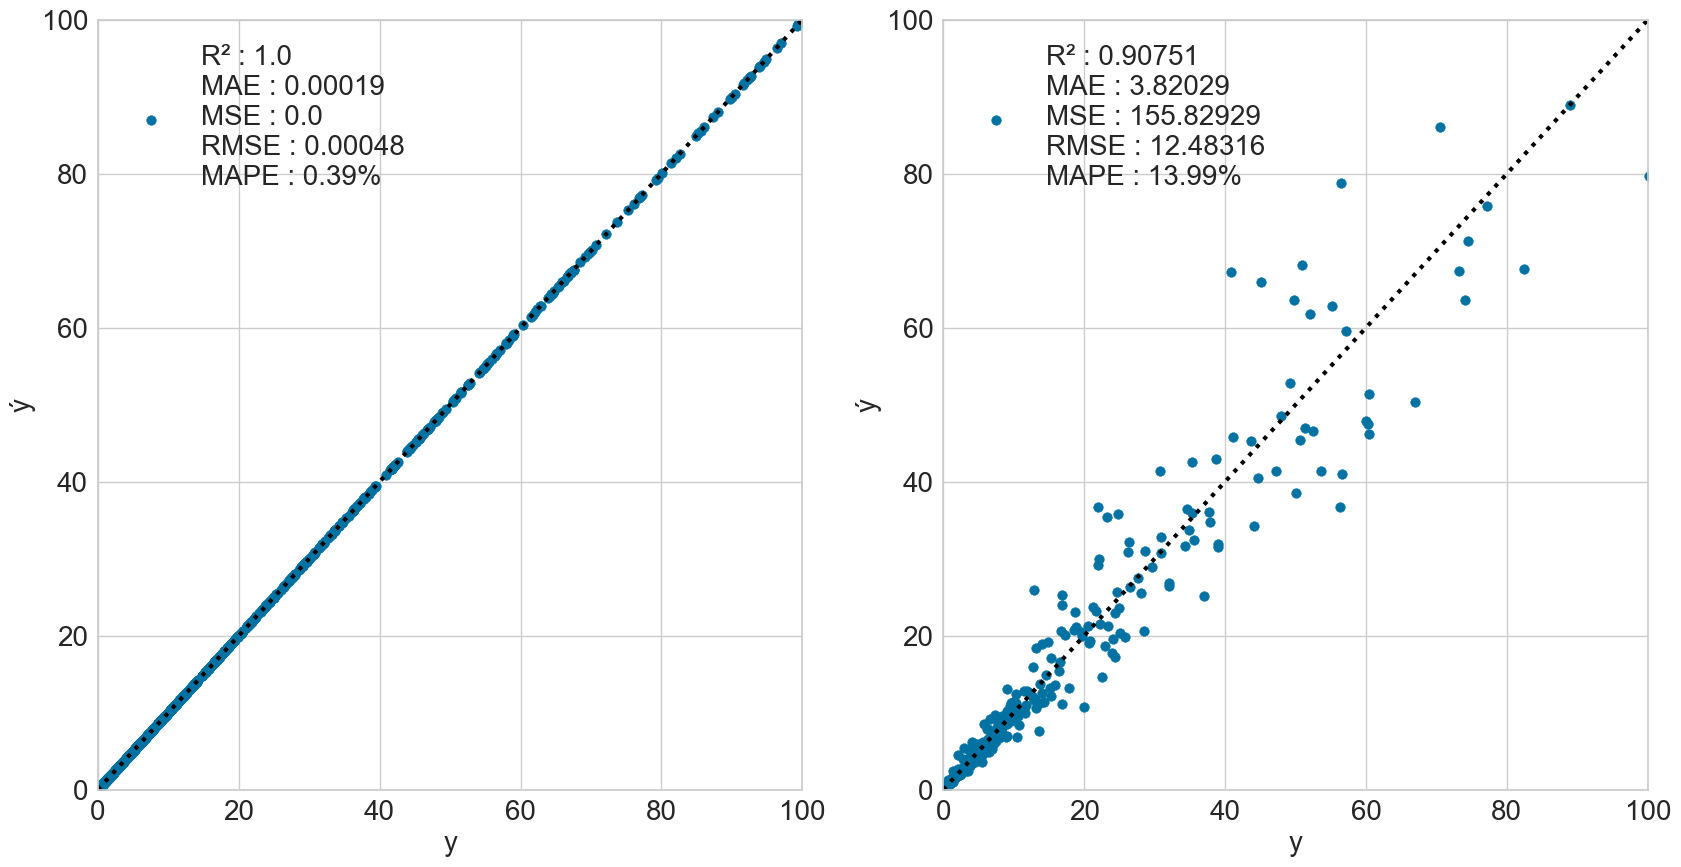

In [45]:
train_data = pd.concat([X_train,pd.DataFrame(Y_train)], axis=1)

test_data = pd.concat([X_test,pd.DataFrame(Y_test)], axis=1)


train_data.head()


verify_plot(model, train_data, test_data, param, xlim=[0,100], ylim=[0,100], legend=True, x_txt="", y_txt="")




In [47]:
temp = model.predict(X_test)

X_test_reset = X_test.reset_index(drop=True)
Y_test_reset = Y_test.reset_index(drop=True)

# 새로운 데이터프레임 temp2와 concat 시도

result = pd.concat([X_test_reset,Y_test_reset, pd.DataFrame(temp)],axis=1)
result_sorted = result.sort_values(by=param, ascending=True)
result_sorted.head(150)

,freq,w1,l1_leg,l1_top,l2,h1,l1_center,Tx_turns,Tx_width,Tx_height,Tx_space_x,Tx_space_y,Tx_preg,Rx_width,Rx_height,Rx_space_x,Rx_space_y,Rx_preg,g2,Tx_layer_space_x,Tx_layer_space_y,wire_diameter,strand_number,Tx_current,magnetizing_current_optimetric,magnetizing_copperloss_Rx1,0
717,160.0,79.0,4.9,1.6,30.0,2.23,25.0,6.0,0.59,0.59,2.7,5.0,0.23,7.7,0.2,1.4,4.7,0.07,0.54,4.4,1.4,0.08,27.0,3.0,0.1177,9.42777,11.150703
61,325.0,95.0,4.4,1.8,25.1,2.76,9.0,7.0,0.53,0.53,4.7,1.1,0.10,8.2,0.2,2.0,3.6,0.10,0.73,3.7,0.9,0.07,29.0,6.0,0.2046,14.01184,15.137108
849,245.0,181.0,4.4,1.9,29.5,2.87,16.0,5.0,0.84,0.84,3.7,4.2,0.24,5.9,0.2,1.8,3.8,0.08,2.38,3.8,2.3,0.06,99.0,6.0,0.3871,18.08360,20.563162
352,335.0,124.0,5.2,1.4,29.6,2.71,15.0,5.0,0.65,0.65,1.3,3.5,0.13,15.1,0.2,4.5,5.0,0.06,0.62,2.7,0.5,0.06,59.0,6.0,0.1752,19.06554,16.384743
116,360.0,44.0,2.9,1.6,23.3,2.79,5.0,10.0,0.27,0.27,3.9,5.0,0.27,8.3,0.2,0.9,3.4,0.26,2.74,0.6,0.2,0.05,15.0,8.0,0.2859,22.73135,31.510653
830,195.0,88.0,9.9,1.2,26.0,2.88,19.0,6.0,0.73,0.73,4.0,4.7,0.09,7.7,0.2,1.6,1.5,0.08,0.19,2.0,1.5,0.07,55.0,6.0,0.1330,22.73979,22.878154
809,390.0,156.0,3.0,0.6,27.4,2.43,7.0,5.0,0.69,0.69,0.3,0.8,0.16,13.4,0.3,4.5,2.7,0.05,0.49,0.9,0.6,0.06,67.0,6.0,0.1649,24.78600,23.311348
804,360.0,80.0,8.1,1.7,19.9,2.76,21.0,7.0,0.78,0.78,2.5,3.3,0.08,4.2,0.3,4.4,0.4,0.15,1.29,2.3,1.0,0.06,85.0,10.0,0.3002,25.03072,21.895882
858,185.0,89.0,4.8,1.4,28.6,2.99,11.0,8.0,0.44,0.44,4.5,3.3,0.17,4.6,0.1,4.4,3.9,0.14,2.00,2.0,1.3,0.05,39.0,5.0,0.2547,25.46158,28.438728
355,150.0,133.0,5.4,0.9,29.0,2.85,25.0,6.0,0.43,0.43,0.1,1.8,0.22,10.3,0.6,4.2,1.8,0.16,0.64,0.7,1.1,0.05,37.0,7.0,0.1482,26.00482,29.648731
